In [3]:
# Falls noch nicht installiert...
!pip install dimod
!pip install cplex


## Allgemeine Bibliotheken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Für Brute-Force Lösung
import dimod

# Nutze IBM's CPLEX für die klassische Optimierun
import docplex.mp
import cplex
from docplex.mp.advmodel import AdvModel as Model  

# Bibliotheken für Quantenalgorithmen mit Qiskit
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit.algorithms.optimizers import COBYLA

from qiskit import BasicAer, Aer, execute# QuantumCircuit

from qiskit.utils import algorithm_globals, QuantumInstance


from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo)    # combines the previous three converters


# Das Würfelproblem

* Würfel besteht aus Pappe (1) oder Papier (0). Mehrerlös für einen Pappwürfel ggü einem Papierwürfel: 50. 
* Die Kanten des Würfels können verstärkt werden (1) oder nicht (0). Erlös für Kantenverstärkung: 10
* Der Würfel kann mit Schaumstoff gefüllt werden (1) oder nicht (0). Erlös für Füllung: 20
* Der Würfel wird bemalt (1) oder nicht (0). Erlös für Bemalung: 30



Dabei ist folgendes zu beachten:

* Wenn der Würfel gefüllt und verstärkt wird, dann kostet das -30.
* Wenn der Würfel aus Pappe ist und verstärkt wird dann kostet das -30
* Wenn der Würfel bemalt wird und gefüllt ist, dann kann er für 40 mehr verkauft werden

Welcher Würfel soll produziert werden, damit der Erlös maximiert werden kann?

#### Aufgabe:

Versuche dieses Problem "von Hand" (=Intuition, Taschenrechner, Excel etc.) zu lösen. 

#### Lessons Learned:

Für "kleine" Probleme ist eine Lösung "von Hand" machbar; für "große" Probleme nicht ... :-(

## Formulierung als mathematisches Optinierungsproblem

mit einer bestimmten Struktur ...

Verpacke die vorhandenden Information in mathematische Variablen

1. Vektor b = Erlöse aus dem Würfelverkauf
2. Matrix C = Korrekturen der Erlöse, die immer von 2 (!) Komponenten abhängen


In [4]:
# Papier/Pappe, Kanten, Füllen, Bemalen

b = np.array([50,10,20,30])

C=np.array([[0,-30,0,0],[-30,0,-30,0],[0,-30,0,40],[0,0,40,0]])

print("b=",b)
print()
print("C=",C)

b= [50 10 20 30]

C= [[  0 -30   0   0]
 [-30   0 -30   0]
 [  0 -30   0  40]
 [  0   0  40   0]]


Die Aufgabe besteht dann darin, die Größe $H$ zu maximieren:

\begin{align} H=\frac{1}{2}\mathbf{a}^T\mathbf{C}\mathbf{a} + \mathbf{b}^T\mathbf{a}\end{align}


Hierbei handelt es sich um ein 

**Q**uadratic **U**nconstrained **B**inary **O**ptimization

Problem:

\begin{align} H=\sum_{i<j} C_{ij}a_i a_j + \sum_{i} b_i a_i \text{ mit } \forall a_i \in {0,1} \text{ und } C_{ij} \in \mathbb{R},b_i \in \mathbb{R} \end{align}

Obwohl an dieser Stelle ohne weitere Relevanz, wollen wir im Vorgriff auf das Folgende lieber ein Minimierung-Problem anstatt einem Maximierungsproblem lösen. 

Dies ist z.B. über 

$ b \rightarrow -b $ und  $ C \rightarrow -C $

zu erreichen.

Die naheliegende - und vermutlich einfachste - Lösung des Problems besteht darin, alle 16 Kombinationen von $ [0,1]^4$ durchzuprobieren, $H$ auszurechnen und dann die Kombination mit dem geringsten Wert von $H$ als Lösung zu nehmen.

Dies könnte man per Hand programmieren oder man verwendet den "ExactSolver" aus dem Python-Paket dimod: 

   Bemalen Füllen Kanten Pappe energy num_oc.
9        1      1      0     1 -140.0       1
8        1      1      0     0  -90.0       1
10       1      1      1     1  -90.0       1
14       1      0      0     1  -80.0       1
6        0      1      0     1  -70.0       1
11       1      1      1     0  -70.0       1
13       1      0      1     1  -60.0       1
1        0      0      0     1  -50.0       1
12       1      0      1     0  -40.0       1
2        0      0      1     1  -30.0       1
15       1      0      0     0  -30.0       1
5        0      1      1     1  -20.0       1
7        0      1      0     0  -20.0       1
3        0      0      1     0  -10.0       1
0        0      0      0     0    0.0       1
4        0      1      1     0    0.0       1
['BINARY', 16 rows, 16 samples, 4 variables]


<AxesSubplot:>

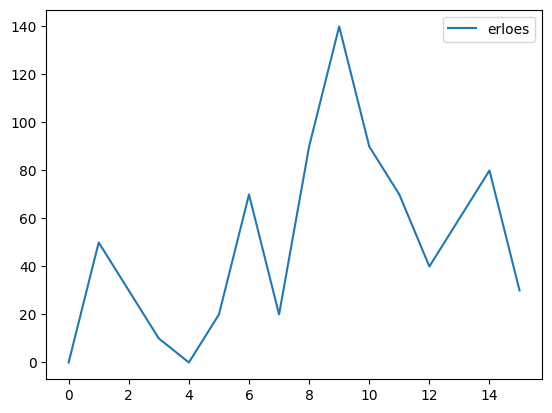

In [5]:
bqm=dimod.BinaryQuadraticModel(-b,-C/2,dimod.BINARY)
bqm.relabel_variables({0:"Pappe",1:"Kanten",2:"Füllen",3:"Bemalen"})

solver = dimod.ExactSolver()
solutions = solver.sample(bqm)

print(solutions)

erloes =-solutions.to_pandas_dataframe()
erloes=erloes.rename(columns={'energy': 'erloes'})
erloes.plot(y="erloes")

## Möglichkeit von Zwangsbedingungen/Einschränkungen (="Constraints")

Wie können nun zusätzliche Bedingungen eingebaut werden?

Zum Beispiel könnte es sein, dass aus Produktionsgründen ein Würfelimmer genau zwei "Features" haben soll: z.B. Pappe & bemalt oder bemalt & Kanten verstärkt etc.

In unserer mathematischen Formulierung bedeutet dies:

$\sum_i a_i = 2$

oder 

$\sum_i a_i -2 = 0$


Diese Zwangsbedingung kann man nun in unsere Formulierung des Optimierungsproblems als Strafterm einbauen:

Strafterm oder "penalty term": $P= W \cdot(\sum_i a_i -2)^2$

Hierbei ist W ist freier Parameter, der bestimmt, wie stark der Strafterm wirkt: Is W klein, dann werden Lösungen, welche die Zwangsbedingung nicht erfüllen nicht "genug bestraft"; ist W zu groß, dann dominiert der Strafterm ggü dem eigentlichen Problem $ \rightarrow$ finde passendes W durch ausprobieren.probieren.

Unser Optimierungeproblem lautet also:

\begin{align} H=\sum_{i<j} C_{ij}a_i a_j + \sum_{i} b_i a_i + W \cdot(\sum_i a_i -2)^2
\text{ mit } \forall a_i \in {0,1} \text{ und } C_{ij} \in \mathbb{R}, W,b_i \in \mathbb{R} \end{align}

Da für binäre Variablen gilt $a_i^2=a_i$ lässt sich durch eine entsprechende Umdefinition von $C_{ij}$ und $b_i$ das Optimierungsproblem auch wieder als normales QUBO schreiben!

BinaryQuadraticModel({'Pappe': -230.0, 'Kanten': -190.0, 'Füllen': -200.0, 'Bemalen': -210.0}, {('Kanten', 'Pappe'): 150.0, ('Füllen', 'Pappe'): 120.0, ('Füllen', 'Kanten'): 150.0, ('Bemalen', 'Pappe'): 120.0, ('Bemalen', 'Kanten'): 120.0, ('Bemalen', 'Füllen'): 80.0}, 240.0, 'BINARY')
   Bemalen Füllen Kanten Pappe energy num_oc.
8        1      1      0     0  -90.0       1
9        1      1      0     1  -80.0       1
14       1      0      0     1  -80.0       1
6        0      1      0     1  -70.0       1
12       1      0      1     0  -40.0       1
2        0      0      1     1  -30.0       1
11       1      1      1     0  -10.0       1
4        0      1      1     0    0.0       1
13       1      0      1     1    0.0       1
1        0      0      0     1   10.0       1
15       1      0      0     0   30.0       1
5        0      1      1     1   40.0       1
7        0      1      0     0   40.0       1
3        0      0      1     0   50.0       1
10       1      1      

<AxesSubplot:>

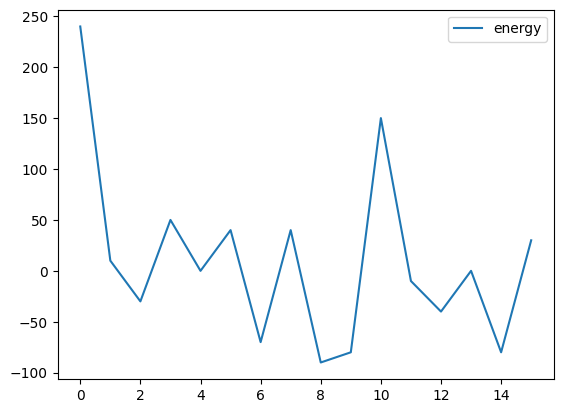

In [6]:
bqm=dimod.BinaryQuadraticModel(-b,-C/2,dimod.BINARY)
bqm.relabel_variables({0:"Pappe",1:"Kanten",2:"Füllen",3:"Bemalen"})
W= 60
bqm.add_linear_equality_constraint([("Pappe",1),("Kanten",1),("Füllen",1),("Bemalen",1)],W,-2)
print(bqm)

solver = dimod.ExactSolver()
solutions = solver.sample(bqm)
print(solutions)

energies =solutions.to_pandas_dataframe()
energies.plot(y="energy")

## Lösung des QUBO-Problems klassisch

Sobald die Anzahl der zu optimierenden binären Variablen größer und größer werden, müssen immer mehr potenzielle Lösungen per "brute force" durchprobiert werden. Bei N binären Variablen sind das $2^N$ Lösungen.

Da dies irgenwann zu lang dauert, wurden "klassisch" Lösungsalgorithmen entwickelt.
Problematik: Ist eine gefundene Lösung wirklich DIE BESTE oder gibt es nicht noch eine bessere Lösung? 

Um ein QUBO klassisch zu lösen gibt es eine Vielzahl kommerzieller und open-Source Lösungen auf dem Markt. Wir wollen hier CPLEX von IBM verwenden, da es später einen einfachen Übergang in die Welt des Quantencomputings erlaubt.

In [7]:
## "Schönere Darstellung unseren Problems:"

comp=["Pappe","Kanten","Füllen","Bemalen"]
df_comp=pd.DataFrame()

df_comp = pd.DataFrame(b,columns=['b'])    
df_comp.index = ["Pappe","Kanten","Füllen","Bemalen"]

C=pd.DataFrame(C/2,columns=["Pappe","Kanten","Füllen","Bemalen"],index=["Pappe","Kanten","Füllen","Bemalen"])


In [8]:
C

,Pappe,Kanten,Füllen,Bemalen
Pappe,0.0,-15.0,0.0,0.0
Kanten,-15.0,0.0,-15.0,0.0
Füllen,0.0,-15.0,0.0,20.0
Bemalen,0.0,0.0,20.0,0.0


In [9]:
## Definiere und benamse das Modell
mdl = Model(name='Optimiere_Wuerfel')

## Definiere die Entscheidungsvariablen und gebe ihnen einen Namen:
df_comp['bin'] = mdl.binary_var_list(comp, name='bin')


## Berechne den Erlös pro Feature 
gain1 = mdl.dot(df_comp.bin,df_comp.b)

#mdl.add_constraint(mdl.sum(df_comp['bin']) == budget)

## Berechne die Effekte wenn zwei Komponenten paralle auftreten
bini = df_comp.bin
gain2 = mdl.sum((float(C[s1][s2]) * bini[s1] * bini[s2]) for s1 in df_comp.index for s2 in df_comp.index)

# Addiere beide Bestandteile der Erlösfunktion
obj=gain1+gain2

## Und Minimiere die negative Zielfunktion
mdl.minimize(-obj)

mdl.prettyprint()

assert mdl.solve(url=None, key=None), "Solve failed"

mdl.report()
sol=mdl.solution.get_objective_value()
print("Solution:",sol)

Solution=[]
for i in range(4):
    Solution.append(df_comp['bin'][i].solution_value)    

print(df_comp['bin'].values)
print("Bitstring:",Solution)


// This file has been generated by DOcplex
// model name is: Optimiere_Wuerfel
// var contrainer section
dvar bool bin[4];

minimize
 - 50 bin_Pappe - 10 bin_Kanten - 20 bin_Füllen - 30 bin_Bemalen [
 30 bin_Pappe*bin_Kanten + 30 bin_Kanten*bin_Füllen
 - 40 bin_Füllen*bin_Bemalen ];
 
subject to {

}
* model Optimiere_Wuerfel solved with objective = -140.000
Solution: -140.0
[bin_Pappe bin_Kanten bin_Füllen bin_Bemalen]
Bitstring: [1.0, 0, 1.0, 1.0]


In [10]:
## Und das Selbe unter Berücksichtigung der Zwangsbedingung:


## Definiere und benamse das Modell
mdl = Model(name='Optimiere_Wuerfel')

## Definiere die Entscheidungsvariablen und gebe ihnen einen Namen:
df_comp['bin'] = mdl.binary_var_list(comp, name='bin')


## Berechne den Erlös pro Feature 
gain1 = mdl.dot(df_comp.bin,df_comp.b)

mdl.add_constraint(mdl.sum(df_comp['bin']) == 2)

## Berechne die Effekte wenn zwei Komponenten paralle auftreten
bini = df_comp.bin
gain2 = mdl.sum((float(C[s1][s2]) * bini[s1] * bini[s2]) for s1 in df_comp.index for s2 in df_comp.index)

# Addiere beide Bestandteile der Erlösfunktion
obj=gain1+gain2

## Und Minimiere die negative Zielfunktion
mdl.minimize(-obj)

mdl.prettyprint()

assert mdl.solve(url=None, key=None), "Solve failed"

mdl.report()
sol=mdl.solution.get_objective_value()
print("Solution:",sol)

Solution=[]
for i in range(4):
    Solution.append(df_comp['bin'][i].solution_value)    

print(df_comp['bin'].values)
print("Bitstring:",Solution)


// This file has been generated by DOcplex
// model name is: Optimiere_Wuerfel
// var contrainer section
dvar bool bin[4];

minimize
 - 50 bin_Pappe - 10 bin_Kanten - 20 bin_Füllen - 30 bin_Bemalen [
 30 bin_Pappe*bin_Kanten + 30 bin_Kanten*bin_Füllen
 - 40 bin_Füllen*bin_Bemalen ];
 
subject to {
 bin_Pappe + bin_Kanten + bin_Füllen + bin_Bemalen == 2;

}
* model Optimiere_Wuerfel solved with objective = -90.000
Solution: -90.0
[bin_Pappe bin_Kanten bin_Füllen bin_Bemalen]
Bitstring: [0, 0, 1.0, 1.0]


#### Fazit:

Es ergeben sich die selben Lösungen wie mit Brute-Force; mit den in CPLEX implementierten Algorthmen liessen sich aber auch größere Probleme lösen.

## Und wie bekommt man dieses Problem nun auf den Quantencomputer?

#### Strategie:

* Ein Quantencomputer besteht aus Qubits. Diese können nicht nur (wie die klassischen Bits) die Werte 0 und 1 annehmen, sondern auch alle Werte "zwischendrin": $\psi = a|0 \rangle + b |1\rangle$ mit a,b komplexe Zahlen.
* Sobald man aber ein Qubit misst, muss es sich entscheiden ob es eine 0 (mit Wahrscheinlichkeit $|a|^2$) 
oder 1 (mit Wahrscheinlichkeit $|b|^2$) wird.
* Nimm vier Qubits; führe bestimmte "Manipulationen" mit diesen aus $\rightarrow$ generiere einen Bitstring der Länge 4 aus 0 und 1, z.B. [0,1,1,0].
* Der wichtige (und kritische) Punkt ist jetzt, welche "Manipulationen" man mit den 4 Qubits durchführt, damit am Ende der Prozedur, der optimale Bitstring gemessen wird .... 



#### Strategie von QAOA:

* Die oben erwähnten "Manipulationen" lassen sich formal/mathematisch durch eine unitäre Matrix U beschreiben.
* Eine unitäre Matrix wiederum lässt sich als $U=e^{iH}$ mit einer hermiteschen Matrix H beschreiben.
* Als H verwenden wir an dieser Stelle eine "quantenmechanische" Version unseres QUBOs:

\begin{align}\ H=\sum_{i<j} C_{ij}a_i a_j + \sum_{i} b_i a_i \rightarrow \end{align} 
$$ H_{Ising}=\sum_{i<j} J_{i,j} {\hat\sigma_{z}^{(i)}} {\hat\sigma_{z}^{(j)}}+ \sum_{i} h_i {\hat\sigma_{z}^{(i)}}$$



Aus den binären Entscheidungsvariablen $a_i$ werden also die sog. "Pauli z-Matrizen" und dieser Hamilton-Operator ist hermitesch! Physiker kennen dies als "Ising-Modell". $J_{i,j}$ und $h_i$ lassen sich aus den ursprünglichen Parametern des Problems (C und b) berechnen.


* Eine andere Betrachtungsweise ist, dass wir unser Problem "Finde den Bitstring" der unsere Zielfunktion minimiert" umformuliert haben in das Problem "Finde den kleinsten Eigenwert der Matrix H"! Quantencomputing ist in dieser Betrachtung eigentlich nichts anderes als lineare Algebra (Vektoren, Matrizen, ..) mit komplexen Zahlen. 
Spoiler: Wir werden unten zeigen, dass wir "unser kleines Problem" auf diese Art und Weise lösen können - bei richtig großen Matrizen (=viele Qubits) geht das nicht mehr, da der Hauptspeicher eines klassischen Computers zu klein ist. 

* Da wir nun in der Quantenmechanki angekommen sind, suchen wir nach einem Zustand $| \Psi \rangle$ welcher den Erwartungswert dieses Hamilton-Operaors minimiert:  $\langle \Psi | H  | \Psi \rangle \rightarrow min$.



* Starte mit einem parametrisierten Ansatz $| \Psi (\alpha, \beta, \gamma ...) \rangle$ und variere die Parameter so lange, bis das Minimum erreicht ist. Das ist die allg. Idee der sog. "Variationellen Quantenalgorithmen (VQA)".

* QAOA ist ein Spezialfall davon; hier macht man keinen möglichst allgemeinen Ansatz (mit vielen Parametern ...), sondern lässt sich beim Ansatz durch die Physik inspirieren:

* Motiviert durch das "Adiabatentheorem" (ein System bei dem man Änderungen nur langsam genug vornimmt bleibt immer in seinem Grundzustand) wird schliesslich bei QAOA folgender Ansatz gemacht:

$$ H_{final} = \alpha H_{mixer} + \beta H_{Ising}$$ mit $$ H_{mixer}=\sum_i {\hat\sigma_{x}^{(i)}}$$
 


* $U=e^{iH_{final}}$ lässt sich nun nicht nur einmal, sondern mehrmals mit jeweils anderen Parametern $\alpha$ und $\beta$ anwenden und man erhofft sich, dass sich mit steigender Anzahl der Anwendungen der Grundzustand von $H_{Ising}$ besser finden lässt.
* Die Parameter $\alpha$ und $\beta$ werden mittels eines klassischen Optimierers solange angepasst, bis der Bitstring als Messergebnis kein besseres Ergebnis mehr liefert.

Eine interessante und lesenswerte Einführung in QAOA welche die unterschiedlichen Fäden verknüpft, findet sich unter:

https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained

#### Gute Nachricht:
In vielen Frameworks wie z.B. Qiskit von IBM muss man QAOA nicht von Hand implmentieren - es gibt hierfür bereits definierte Funktionen (oder Klassen) die man out-of-the-box verwenden kann

In [11]:
## Helper functions: Source: IBM 

def index_to_selection(i):
    s = "{0:b}".format(i).rjust(4)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(4))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [12]:
# Konvertiere das in CPLEX definierte Optimierungsproblem in ein QUBO:
mod = from_docplex_mp(mdl)

# Verarbeite die Nebenbedinung korrekt
lineq2penalty = LinearEqualityToPenalty(W) 
qp = lineq2penalty.convert(mod)

# Wandle das QUBO-Problem in einen Hamilton-Operator um
op,offset=op, offset = qp.to_ising()
print("Konstante:",offset)
print("Matrix:",op)

Konstante: 10.0
Matrix: 17.5 * IIIZ
- 10.0 * IIZI
+ 12.5 * IZII
+ 25.0 * ZIII
+ 37.5 * IIZZ
+ 30.0 * IZIZ
+ 37.5 * IZZI
+ 30.0 * ZIIZ
+ 30.0 * ZIZI
+ 20.0 * ZZII


Note: Z und I sind jeweils 2x2 Matrizen; Z ist die Paulische z-Matrix. offset ist eine Konstante, welcher Bitstring der Beste ist, ist unabhängig von dieser Konstante!

Formuliert als Matrix hat unser Problem die Größe $2^4=16$ - das ist überschaubar und darstellbar. Da H außerdem diagonal ist, stehen die Eigenwerte in der Diagonalen und wir müssen nur den kleinsten Wert auf der Diagonale suchen: 

dim(H): (16, 16)
---------------------------------------------------------
Matrix H:
[[ 230.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.   40.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.  -40.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.   30.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  -80.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  -10.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.   30.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.   20.    0.    0.    0.
     0.    0.    0.    0.]
 [   0

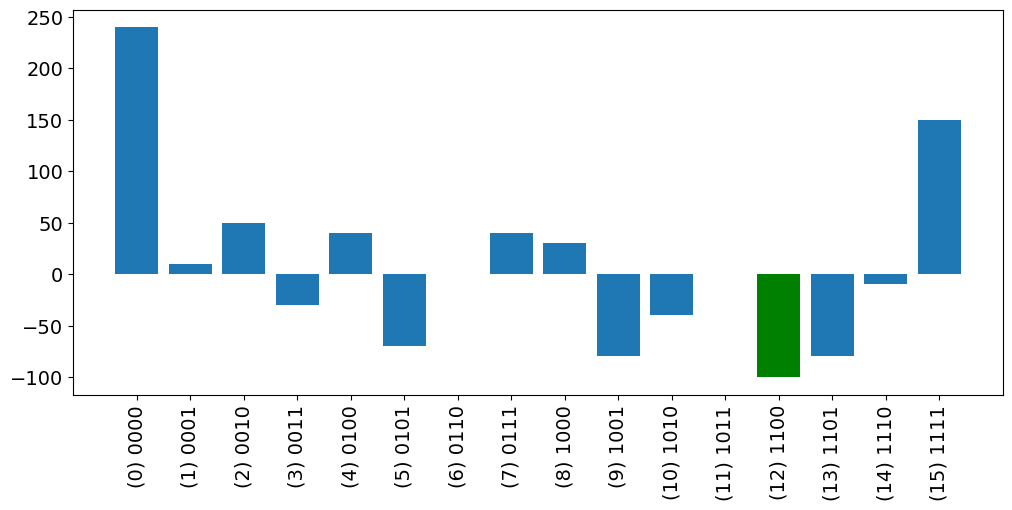

In [13]:
#Show exact spectrum of the Hamiltonian
H=op
n=4
# print Ising Hamiltonian as matrix
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print("---------------------------------------------------------")
print("Matrix H:")
print(H_matrix)
print("---------------------------------------------------------")
print("Diagonalelemente der Matrix H=Eigenwerte")
print(H_matrix.diagonal()+offset)
print("---------------------------------------------------------")
# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), H_matrix.diagonal()+offset)
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:04b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Wie sehen: Der optimale Werte von -90 mit dem Bitstring [0,0,1,1] wird auch hier gefunden! 

Eine andere klassische Möglichkeit besteht darin, die Matrix H mit einer Numpy-Routine zu diagonalisieren:

In [14]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result_numpy = exact_eigensolver.solve(mod)

print(result_numpy)
print_result(result_numpy)

fval=-90.0, bin_Pappe=0.0, bin_Kanten=0.0, bin_Füllen=1.0, bin_Bemalen=1.0, status=SUCCESS
Optimal: selection [0. 0. 1. 1.], value -90.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 1]	-90.0000		1.0000
 [1 1 1 1]	150.0000		0.0000
 [0 1 1 1]	-10.0000		0.0000
 [1 0 1 1]	-80.0000		0.0000
 [1 1 0 1]	0.0000		0.0000
 [0 1 0 1]	-40.0000		0.0000
 [1 0 0 1]	-80.0000		0.0000
 [0 0 0 1]	30.0000		0.0000
 [1 1 1 0]	40.0000		0.0000
 [0 1 1 0]	0.0000		0.0000
 [1 0 1 0]	-70.0000		0.0000
 [0 0 1 0]	40.0000		0.0000
 [1 1 0 0]	-30.0000		0.0000
 [0 1 0 0]	50.0000		0.0000
 [1 0 0 0]	10.0000		0.0000
 [0 0 0 0]	240.0000		0.0000


An dieser Stelle schwenken wir nun auf den Quantencomputer. Zuerst mal noch in der "Statevector-Simulation": D.h. der Rechner führt hier eine exakte Rechnung des quantenmechanischen Problems unter Anwendung des QAOA-Algorithmus durch:

In [15]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=123, seed_transpiler=123)


cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_sv = qaoa.solve(qp)

print(result_sv)
print_result(result_sv)

fval=-90.0, bin_Pappe=0.0, bin_Kanten=0.0, bin_Füllen=1.0, bin_Bemalen=1.0, status=SUCCESS
Optimal: selection [0. 0. 1. 1.], value -90.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-70.0000		0.2361
 [0 0 0 1]	30.0000		0.2000
 [1 0 0 1]	-80.0000		0.1391
 [1 0 0 0]	10.0000		0.1026
 [1 0 1 1]	-80.0000		0.0869
 [1 1 1 0]	40.0000		0.0548
 [0 0 1 1]	-90.0000		0.0498
 [0 0 1 0]	40.0000		0.0276
 [1 1 1 1]	150.0000		0.0248
 [0 1 0 0]	50.0000		0.0248
 [1 1 0 0]	-30.0000		0.0213
 [0 0 0 0]	240.0000		0.0103
 [1 1 0 1]	0.0000		0.0097
 [0 1 1 0]	0.0000		0.0079
 [0 1 1 1]	-10.0000		0.0025
 [0 1 0 1]	-40.0000		0.0017


Als nächstes nutzen wir einen Quanten-Simulator, d.h. immer noch einen klassischen Rechner, der die Funktionsweise eines 
idealen=perfekten Quantencomputers simuliert. Das funktioniert in der Praxis bis zu ca. 30 Qubits:

In [16]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=123, seed_transpiler=123,shots=8192)

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_qaoa = qaoa.solve(qp)

print(result_qaoa)
print(result_qaoa.samples)

fval=-90.0, bin_Pappe=0.0, bin_Kanten=0.0, bin_Füllen=1.0, bin_Bemalen=1.0, status=SUCCESS
[SolutionSample(x=array([0., 0., 1., 1.]), fval=-90.0, probability=0.0277099609375, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 0., 1.]), fval=-80.0, probability=0.200927734375, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 1., 1.]), fval=-80.0, probability=0.081298828125, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 0., 1., 0.]), fval=-70.0, probability=0.10693359374999999, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 1., 0., 1.]), fval=-40.0, probability=0.165771484375, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([1., 1., 0., 0.]), fval=-30.0, probability=0.0164794921875, status=<OptimizationResultStatus.SUCCESS: 0>), SolutionSample(x=array([0., 1., 1., 1.]), fval=-10.0, probability=0.0386962890625, status=<OptimizationResultStatus.SUCCESS: 0>

Eine wichtige Kennzahl für die Güte von QAOA ist die sog. Approximation Ratio: Inwieviel % der Fälle wird beim Sampling des Ergebnisses die optimale Lösung ermittelt ?  

Theoretisch wird erwartet, dass mit steigender Anzahl von "reps", d.h. die Anzahl der Anwendungen von U, die Approximation Ratio steigt.

In [17]:
f_best=-90
f_worst=240

uu=0
r=0
for i in range(len(result_qaoa.samples)):
 r+=(result_qaoa.samples[i].fval-f_worst)/(f_best-f_worst)*result_qaoa.samples[i].probability
 uu+=result_qaoa.samples[i].probability
print('-----------------------------')    
print(uu)    
print("Approx.Ratio:",r/uu)

-----------------------------
1.0
Approx.Ratio: 0.8215775923295453


### Lösung des Problem auf einer echten Quantemhardware von IBM:

In [18]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

In [19]:
# Lade die Account Informationen
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [20]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5
and not x.configuration().simulator
and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


Eine Möglichkeit wäre, einfach das Backend auf die "echte" Maschine zu wechseln und den Job loszuschicken....
das hat aber den Nachteil, dass der Job ganz oft eine Anfrage über das Netz an den Quantenrechner schickt und dann lokal die Ergebnisse sammelt... Das ist fehleranfällig und sobald die Netzwerkverbindung steht, bricht der Job ab :-( 

Bessere Lösung: Nutzung von RUNTIME mit der Idee, dass der gesamt Auftrag (Quantenalgorithmus + klassischer Optimierungsteil) an die IBM-Cloud gesendet und ausgeführt wird. Über die Job-Idee kann dann das Ergebnis jederzeit abgerufen werden!

In [21]:
program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

In [22]:
# Define the cost operator to run.
op = H

# SPSA helps deal with noisy environments.
optimizer = COBYLA()

# We will run a depth two QAOA.
reps = 1

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_belem"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2 ** 13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
    "alpha":1.0
}

In [23]:
job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

In [24]:
print(f"Job id: {job.job_id()}")
print(f"Bob status: {job.status()}")

Job id: ccvv5cdkehlsssif68vg
Bob status: JobStatus.QUEUED


In [25]:
result = job.result()
result

{'optimizer_time': 198.26266765594482,
 'optimal_value': -22.4462890625,
 'optimal_point': array([2.05475494, 0.74076726]),
 'optimal_parameters': None,
 'cost_function_evals': 33,
 'eigenstate': {'0000': 0.17780947932407878,
  '0001': 0.16572815184059708,
  '0010': 0.20070675904164265,
  '0011': 0.20521758650880778,
  '0100': 0.28168369339562416,
  '0101': 0.3031813736239415,
  '0110': 0.2415566380271923,
  '0111': 0.3316403949498613,
  '1000': 0.30095875444153475,
  '1001': 0.3843241836327764,
  '1010': 0.28980057798424075,
  '1011': 0.2722070529716304,
  '1100': 0.2004024271621978,
  '1101': 0.15229366163764005,
  '1110': 0.17293705954045824,
  '1111': 0.1711632992203644},
 'eigenvalue': (-22.4462890625+0j),
 'aux_operator_eigenvalues': None,
 'optimizer_history': {'nfevs': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,

Da die Ausgabe relativ kryptisch ist, sollte diese noch besser aufbereitet werden:

In [26]:
# Hilfsfunktionen von IBM

from collections import defaultdict

def get_cost(bit_str: str) -> float:
    """Return the cost value of the bit string."""
    n, x = len(bit_str), [int(bit) for bit in bit_str[::-1]]
    cost = 0.0
    if sum(x)==2:
        for i in range(n):
            cost+=b[i]* x[i]
        for i in range(n):
            for j in range(n):
                if i != j:
                    cost+=np.array(C)[i,j]*x[i]*x[j]  
    return -cost


def get_port_distribution(result) -> dict:
    """Extract the port distribution from the result.

    Returns:
        A dict of port value: probability.
    """

    state_results = []
    for bit_str, amp in result["eigenstate"].items():
        state_results.append((bit_str, get_cost(bit_str), amp ** 2 * 100))        
   
    vals = defaultdict(int)
    vals1 = defaultdict(int)
    for res in state_results:
        #vals[res[1]] += res[2]
        vals[res[1]] = [res[0], res[2]]
    for res in state_results:
        vals1[res[1]] += res[2]
    return dict(vals), dict(vals1)

In [27]:
dic2,dic3 = get_port_distribution(result)

Gefundene Lösungen und ihre Wahrscheinlichkeiten (in Prozent):

In [28]:
dic3

{-0.0: 59.41162109375,
 -30.0: 4.211425781250001,
 -70.0: 9.19189453125,
 -80.0: 14.770507812500004,
 -40.0: 8.3984375,
 -90.0: 4.016113281249999}

Optimale Lösung und optimaler Bitstring:

In [29]:
max_value=min(dic2, key=(lambda k: dic2[k] and k))

print(max_value)
print(dic2[max_value][0][::-1])

-90.0
0011


In [30]:
f_best=-130
f_worst=240

uu=0
r=0
for i in dic3.keys():
   r+=(i-f_worst)*dic3[i]/(f_best-f_worst)
   print(dic3[i])
   uu+=dic3[i]
print('-----------------------------')    
print(uu)    
print(r/uu)  

59.41162109375
4.211425781250001
9.19189453125
14.770507812500004
8.3984375
4.016113281249999
-----------------------------
100.0
0.7202379381334458


Text(0, 0.5, 'Probability')

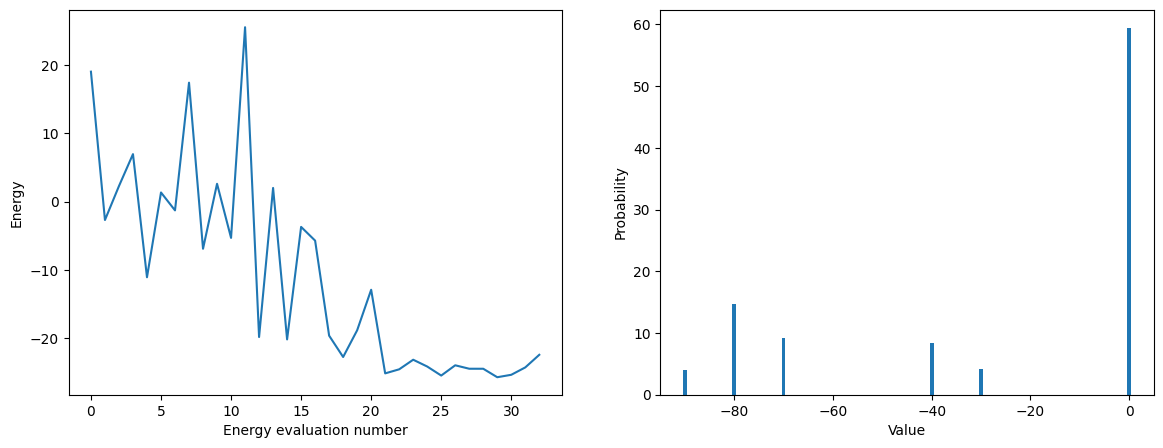

In [31]:
import matplotlib.pyplot as plt

_,port_vals = get_port_distribution(result)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(result["optimizer_history"]["energy"])
axs[1].bar(list(port_vals.keys()), list(port_vals.values()))
axs[0].set_xlabel("Energy evaluation number")
axs[0].set_ylabel("Energy")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Probability")